# Статистический анализ данных сервиса аренды самокатов GoFast.

**Задача:**   
 проанализировать данные популярного сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, их поездках и проверить некоторые гипотезы чтобы помочь бизнесу вырасти.  

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением.  
 Сервисом можно пользоваться:
- без подписки 
   - абонетская плата - 0 руб;
    - стоимость 1 минуты поездки - 8 руб;
    - стоимость старта(начала поездки) - 50 руб;  
 
- с подпиской ULTRA
    - абонетская плата - 199 руб/мес;
    - стоимость 1 минуты поездки - 6 руб;
    - стоимость старта - 0 руб;

## Описание предоставленных данных

**пользователи** `user_go.csv`   
`user_id` - уникальный идентификатор   
`name`- имя пользователя   
`age` - возраст   
`city` - город   
`subcription_type` - тип подписки  

**поездки** `rides_go.csv`   
`user_id` - уникальный идентификатор   
`distance` -  расстояние, которое пользователь проехал в текущей сессии (в метрах)   
`duration` - продолжительность сессии (в минутах) - время с того момента, как пользователь нажал кнопку НАЧАТЬ ПОЕЗДКУ до момента,как он нажал ЗАВЕРШИТЬ ПОЕЗДКУ   
`date` - дата совершения поездки   

**подписки** `subscriptions_go.csv`  
`subscription_type` - тип подписки  
`minute_price` - стоимость одной минуты поездки по данной подписке  
`start_ride_price` - стоимость начала поездки   
`subscription_fee` - стоимость ежемесячного платежа

## Загружаем данные

In [59]:
import pandas as pd
import seaborn as sb
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

## Предобработка

Отформатируем названия столбцов

In [61]:
for table in (users, rides, subscriptions):
    format_title_colunms = list(map(lambda x: x.strip(), table.columns))
    table.columns = format_title_colunms
   

Названия столбцов без пробелов. Отлично.

Посмотрим содержимое датафреймов

In [62]:
def get_info_dataframe(dataframe,
                       transpose=False,
                       count_rows=5
                       ):
    """
    получение основной информации о датафрейме: первые строки датафрейма, количество строк, столбцов, дубликатов, пропусков, типы данных
    `dataframe` - исследуемый датафрейм,  
    `transpose` - перевернуть таблицу на 90°,   
    `count_rows` - чило выводимых строк датафрейма (по умолчанию 5)
    """

    # -----------------сбока таблицы с пропусками---------------------

    # число пропусков

    count_missing = dataframe.isna().sum()

    # доля пропусков

    missing_percent = count_missing/len(dataframe)*100

    # сборка

    df = pd.DataFrame(data={'missing': missing_percent,
                            'count_missing': count_missing
                            }
                      )

    dt = pd.DataFrame(data={'type': dataframe.dtypes})
    df = df.join(dt)

    # цветной бар в столбце с долей пропусков и добапвляем знак %

    df = df.sort_values('missing', ascending=True)

    def color(x):
        if "int" in str(x) or "float" in str(x):
            return "color:#3399ff"
        elif x == "bool":
            return "color: orange"
        else:
            return "color: magenta"

    table_missing = (df.style
                     .set_table_styles([{
                         'selector': 'tr:hover',
                         'props': [('background-color', '#222222'), ('color', 'white')]
                         # [('border-color', 'blue'), ('border-style', 'solid'), ('border-width', '1pt')]
                     }])
                     .map(lambda x: ""
                          if x > 0
                          else "color: #32cd32; font-weight:600",
                          subset=["missing", "count_missing"])


                     .map(color,
                          subset=["type"])

                     .bar(subset="missing",
                          vmax=100,
                          height=90,
                          color="#ff0000",
                          )
                     .set_caption('Пропуски и тип данных')
                     .format(subset="missing",
                             formatter="{:.2f} %")

                     )

    # --------------------------------------

    # -------------------------

    # часть таблицы
    rows, columns = dataframe.shape

    # поиск дубликатов
    dublicat = dataframe.duplicated().sum()

    # харатеристики таблицы
    table_shape_duplicat = pd.DataFrame({"rows": [rows],
                                         "columns": [columns],
                                         "duplicates": [dublicat]})

    table_shape_duplicat = (table_shape_duplicat.style

                            .map(lambda x: "background-color: #ff0000; color:black; font-weight:600"
                                 if x > 0
                                 else "background: #32cd32; color:black; font-weight:600",
                                 subset=["duplicates"]))

    # -------------------- вывод на экран --------------

    table_first_row = dataframe.head(count_rows)
    if transpose:
        display(table_first_row.T)
    else:
        display(table_first_row)

    display(table_shape_duplicat)

    display(table_missing)

    # разделительная линия
    print("===="*10, "\n")

    # -------------------------------------------------

In [63]:
for name, table in zip(
    ("users",
     'rides',
     'subscriprions'),

        (users,
         rides,
         subscriptions)):

    print(name.upper())
    get_info_dataframe(dataframe=table)

USERS


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,rows,columns,duplicates
0,1565,5,31


,missing,count_missing,type
user_id,0.00 %,0,int64
name,0.00 %,0,object
age,0.00 %,0,int64
city,0.00 %,0,object
subscription_type,0.00 %,0,object



RIDES


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,rows,columns,duplicates
0,18068,4,0


,missing,count_missing,type
user_id,0.00 %,0,int64
distance,0.00 %,0,float64
duration,0.00 %,0,float64
date,0.00 %,0,object



SUBSCRIPRIONS


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


,rows,columns,duplicates
0,2,4,0


,missing,count_missing,type
subscription_type,0.00 %,0,object
minute_price,0.00 %,0,int64
start_ride_price,0.00 %,0,int64
subscription_fee,0.00 %,0,int64


Дубликаты есть в `users`. Исправим. и проверим

In [64]:
users = users.drop_duplicates().reset_index(drop=True)
users.duplicated().sum()

np.int64(0)

Приведем столбец `date` к типу данных `datetime`

In [65]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

Всё нормально

Создадим столбец `month` с номером месяца на основе столбца `date` в таблице rides

In [66]:
rides['month'] = pd.DatetimeIndex(rides['date']).month
rides[['date', 'month']].head()

,date,month
0,2021-01-01,1
1,2021-01-18,1
2,2021-04-20,4
3,2021-08-11,8
4,2021-08-28,8


Код работает, продолжаем

Узнаем период, за который взяты данные, и сколько месяцев включают

In [67]:
print(
    f"Данные взяты с {rides['date'].dt.date.min()} по {rides['date'].dt.date.max()}")

Данные взяты с 2021-01-01 по 2021-12-30


Все месяцы 2021 года включены в данные

Краткий вывод:   
В таблице `users` были обнаружены дубликаты. Исходя их набора данных дубликатом могут быть строки с одинаковыми `user_id` (при одинаковых данных о пользователе и типе подписке). Значит причина дубликатов сторона техническая.  
Пометим для баг-репорта.

## Исследовательский анализ данных


###  Изучим частоту встречаемости городов

In [68]:
city = users['city'].value_counts().reset_index()
city.columns = ['city', 'count']
city

,city,count
0,Пятигорск,219
1,Екатеринбург,204
2,Ростов-на-Дону,198
3,Краснодар,193
4,Сочи,189
5,Омск,183
6,Тюмень,180
7,Москва,168


Text(0, 0.5, 'города')

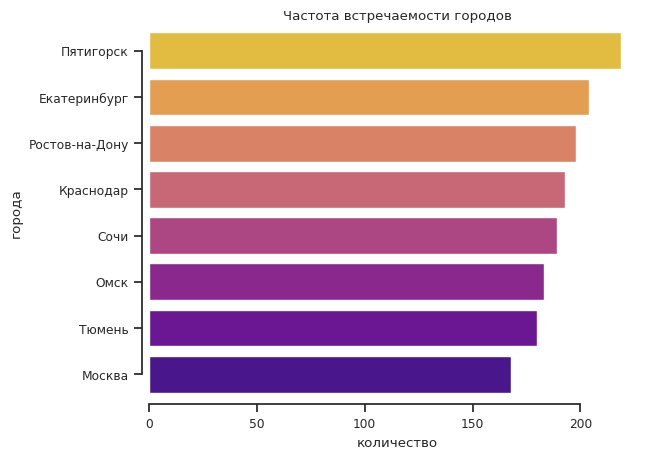

In [69]:
sb.set_theme(style="ticks", font_scale=0.8)
sb.barplot(data=city, y='city', x='count', palette='plasma_r')
sb.despine(offset=5, trim=True)
plt.title("Частота встречаемости городов")
plt.xlabel("количество")
plt.ylabel("города")

Чаще встречается в таблице город Пятигорск, реже - Москва, наверное сервисом GoFast чаще пользуются в Пятигорске.

### Узнаем соотношение пользователей с подпиской и без

In [70]:
users_subscription_type = users.groupby('subscription_type')['user_id'].count()

users_subscription_type = (users_subscription_type
                           .reset_index()
                           .replace('free', 'без подписки')
                           .replace('ultra', 'c подпиской'))

users_subscription_type.rename(columns={'user_id': 'count'}, inplace=True)
users_subscription_type

,subscription_type,count
0,без подписки,835
1,c подпиской,699


In [71]:
users_subscription_type.index = users_subscription_type['subscription_type']

Text(0.5, 1.0, 'Доля пользователей с подпиской и без неё')

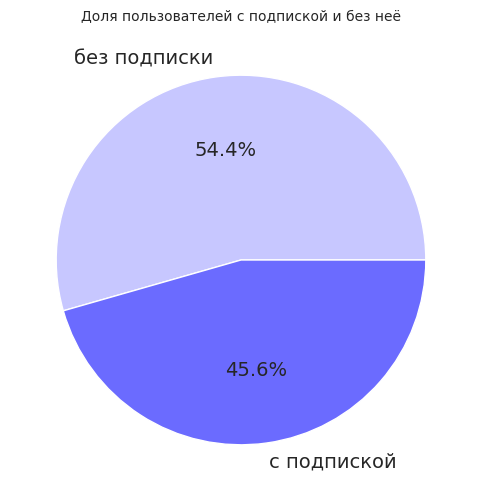

In [72]:
users_subscription_type.plot(kind='pie',
                             y='count',
                             autopct='%1.1f%%',
                             figsize=(6, 6),
                             textprops={'fontsize': 14},
                             colors=['#C7C7FF', '#6B6BFF'],
                             legend=False)
plt.ylabel(None)
plt.title('Доля пользователей с подпиской и без неё', size=10)

Получается чуть больше пользователей без подписки

### Изучим возраст пользователей

In [73]:
(users['age']
 .describe()
 .reset_index()
 .style
 .format(precision=2))

,index,age
0,count,1534.00
1,mean,24.90
2,std,4.57
3,min,12.00
4,25%,22.00
5,50%,25.00
6,75%,28.00
7,max,43.00


Пользуются самокатами пользователи от 12 до 43 лет.

Text(0.5, 1.0, 'Возраст пользователей самокатов')

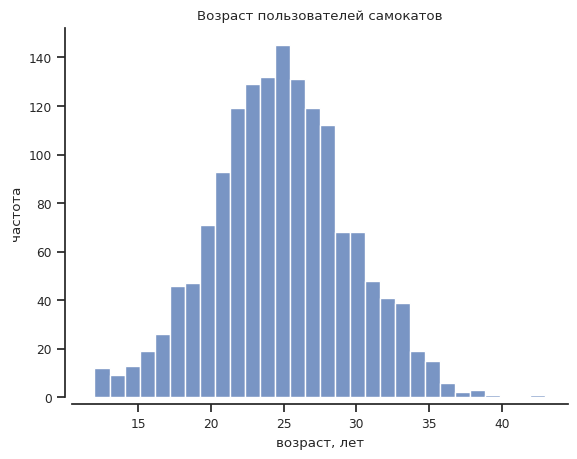

In [74]:
sb.set_theme(style="ticks", font_scale=0.8)
sb.histplot(data=users['age'])
sb.despine(offset=5)
plt.xlabel('возраст, лет')
plt.ylabel('частота')
plt.title('Возраст пользователей самокатов')

Узнаем, люди каких возрастов берут в аренду самокаты чаще всего -   
напишем функцию возвращающую границы интервала в котоом находятся часто встречаемые значения, то есть: границы = среднее +- стандартное отклонение

In [75]:
def get_bounds_center_and_std(value, func='mean'):

    center = value.agg(func)
    STD = value.std()

    results = center - STD, center + STD

    return tuple(map(round, results))

Считаем и выводим на экран

In [76]:

bound_age_min, bound_age_max = get_bounds_center_and_std(users['age'])
print(
    f'Часто арендуют скутеры пользователи от {bound_age_min} до {bound_age_max} лет')

Часто арендуют скутеры пользователи от 20 до 29 лет


### Изучим расстояние которое пользователь преодолел за одну поездку

In [77]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Text(0.5, 1.0, 'Расстояния пройденные пользователями')

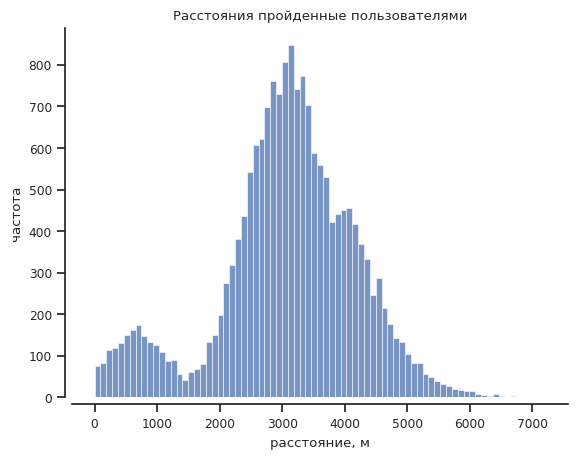

In [78]:
sb.histplot(rides['distance'])
sb.despine(offset=5)
plt.xlabel('расстояние, м')
plt.ylabel('частота')
plt.title('Расстояния пройденные пользователями')

На графике 2 "колокола" - один с 0 до 1500 м, второй - 1500 -7211 м.  

по второму колоколу можно сказать что пользователи чаще преоделевают расстояния с 2500 м до 4500 м.


In [79]:
def get_bounds_tukey(arg):
    ''' Вычисление границ методом Тьюки'''

    q1, q3 = arg.quantile([0.25, 0.75])

    iqr = q3 - q1

    # крайние усы
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    return lower_bound, upper_bound

Text(0.5, 1.0, 'Расстояния пройденные пользователями')

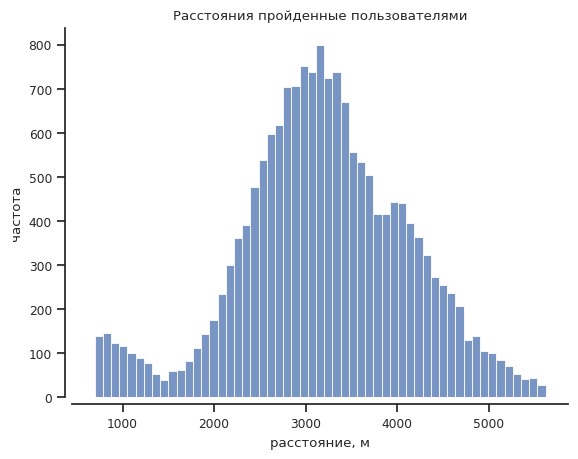

In [80]:
lower_bound, upper_bound = get_bounds_tukey(rides['distance'])

rides_distance = (rides['distance']
                  .loc[
                      (rides['distance'] > lower_bound)
                      &
                      (rides['distance'] < upper_bound)])

sb.histplot(rides_distance)
sb.despine(offset=5)
plt.xlabel('расстояние, м')
plt.ylabel('частота')
plt.title('Расстояния пройденные пользователями')

In [81]:
low_bound, up_bound = get_bounds_center_and_std(rides['distance'], func='median')

print(
    f'В основном пользователи преодолевают расстояния от {low_bound} до {up_bound} метров')

В основном пользователи преодолевают расстояния от 2017 до 4250 метров


### Изучим продолжительность поездок

In [82]:
rides['duration'].describe().reset_index().style.format(precision=2)

,index,duration
0,count,18068.00
1,mean,17.81
2,std,6.09
3,min,0.50
4,25%,13.60
5,50%,17.68
6,75%,21.72
7,max,40.82


Ехать 40 минут на самокате можно, а вот 30 сек наврядли. Посмотрим подробнее

Text(0.5, 1.0, 'Длительность поездок')

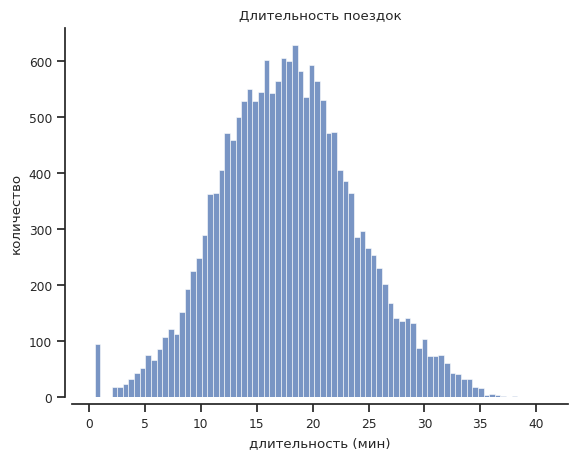

In [83]:
sb.histplot(rides['duration'], bins=80)
sb.despine(offset=5)
plt.xlabel('длительность (мин)')
plt.ylabel('количество')
plt.title('Длительность поездок')

In [84]:
rides['duration'].loc[rides['duration'] < 2].value_counts()

duration
0.5    95
Name: count, dtype: int64

95 поездок завершены за 30 сек. Совпадение? нет не думаю. Аномалия с технической стороны. Пометим для баг-репорта. 

узнаем скорость в км/ ч

In [85]:
rides['speed'] = (rides['distance']/1000) / (rides['duration']/60)

In [86]:
rides['speed'].describe().reset_index().style.format(precision=2)

,index,speed
0,count,18068.00
1,mean,13.79
2,std,44.16
3,min,0.01
4,25%,8.13
5,50%,10.25
6,75%,12.93
7,max,865.32


есть выбросы. Посмотрим какие они

Text(0.5, 0, 'скорость, км/ч')

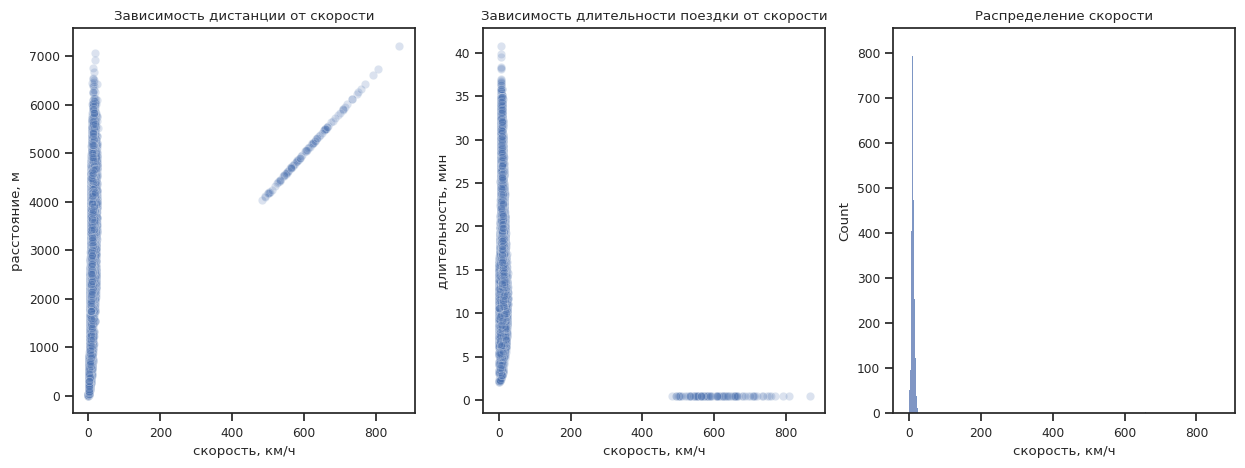

In [87]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sb.scatterplot(rides, y='distance', x='speed', alpha=0.2)
plt.title('Зависимость дистанции от скорости')
plt.ylabel('расстояние, м')
plt.xlabel('скорость, км/ч')

plt.subplot(1, 3, 2)
sb.scatterplot(rides, y='duration', x='speed', alpha=0.2)
plt.title('Зависимость длительности поездки от скорости')
plt.ylabel('длительность, мин')
plt.xlabel('скорость, км/ч')

plt.subplot(1, 3, 3)
sb.histplot(rides['speed'])
plt.title('Распределение скорости')
plt.xlabel('скорость, км/ч')

как видим есть выбросы в скорости

как видим серьезные аномалии в скорости начинаются с дистанции около 4 км

In [88]:
def get_bounds_with_median_mad(value):
    '''Возаращает раницы распределения по методу 3 сигм.    
    Изза выбросов стандвртное отклонение заменяем на MAD для точности'''

    MAD = st.median_abs_deviation(value.dropna())
    # center = value.median()
    
    center = value.median()

    return center - 3*MAD, center + 3*MAD

In [89]:
bounds_min, bounds_max = get_bounds_with_median_mad(rides['speed'])

In [90]:
q = rides['speed'].quantile([0.90,0.95,0.99]).values
q

array([16.12292295, 18.13379614, 22.34058143])

In [91]:
anomal_rides = rides.query('speed > @q[2]')
rides = rides.query('speed <= @q[2]')

Text(0.5, 0, 'скорость, км/ч')

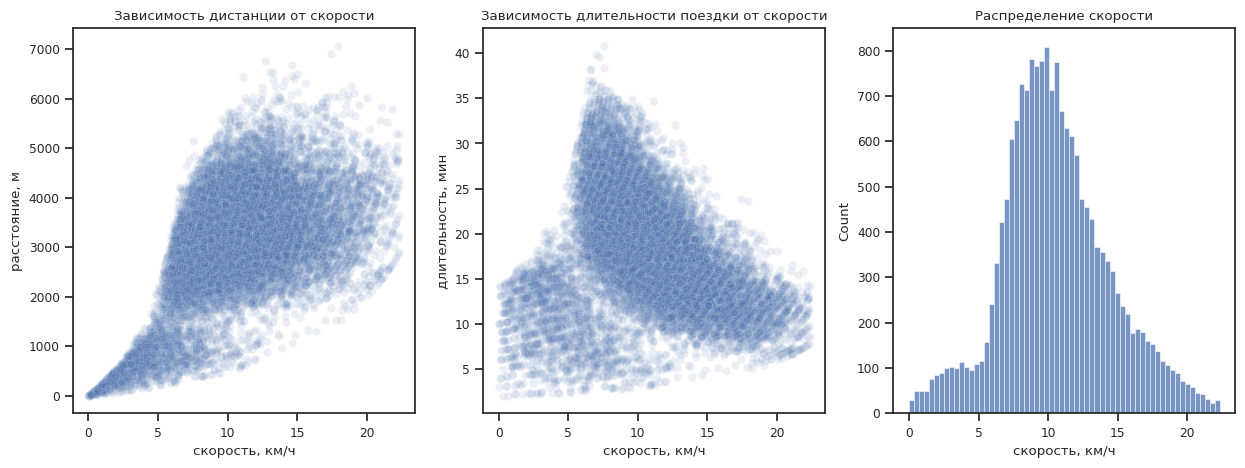

In [92]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sb.scatterplot(rides, y='distance', x='speed', alpha=0.1 )
plt.title('Зависимость дистанции от скорости')
plt.ylabel('расстояние, м')
plt.xlabel('скорость, км/ч')

plt.subplot(1, 3, 2)
sb.scatterplot(rides, y='duration', x='speed', alpha=0.1)
plt.title('Зависимость длительности поездки от скорости')
plt.ylabel('длительность, мин')
plt.xlabel('скорость, км/ч')

plt.subplot(1, 3, 3)
sb.histplot(rides['speed'])
plt.title('Распределение скорости')
plt.xlabel('скорость, км/ч')

от выбросов избавились.

Text(0.5, 0, 'скорость, км/ч')

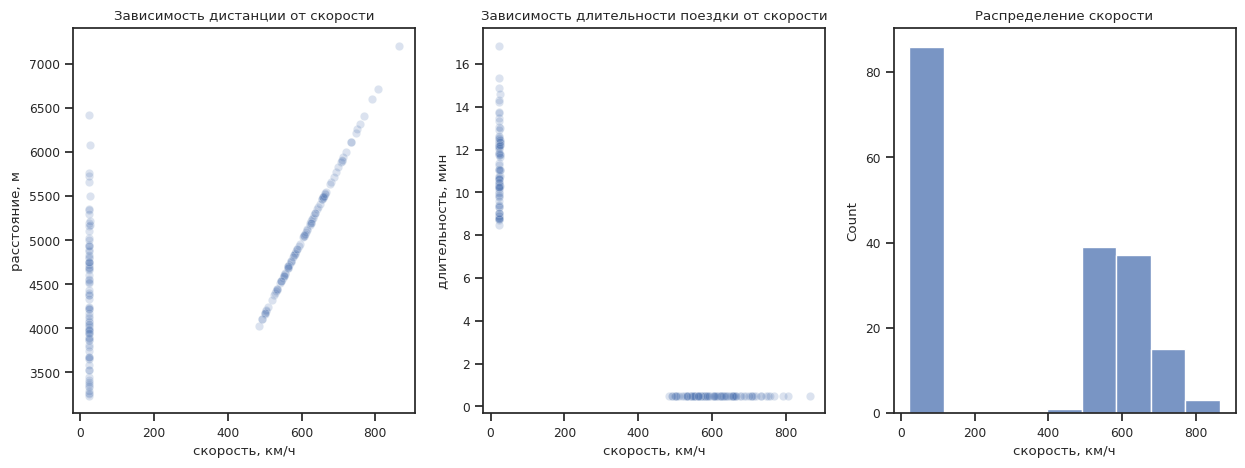

In [93]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sb.scatterplot(anomal_rides, y='distance', x='speed', alpha=0.2)
plt.title('Зависимость дистанции от скорости')
plt.ylabel('расстояние, м')
plt.xlabel('скорость, км/ч')

plt.subplot(1, 3, 2)
sb.scatterplot(anomal_rides, y='duration', x='speed', alpha=0.2)
plt.title('Зависимость длительности поездки от скорости')
plt.ylabel('длительность, мин')
plt.xlabel('скорость, км/ч')

plt.subplot(1, 3, 3)
sb.histplot(anomal_rides['speed'])
plt.title('Распределение скорости')
plt.xlabel('скорость, км/ч')

<Axes: xlabel='speed', ylabel='distance'>

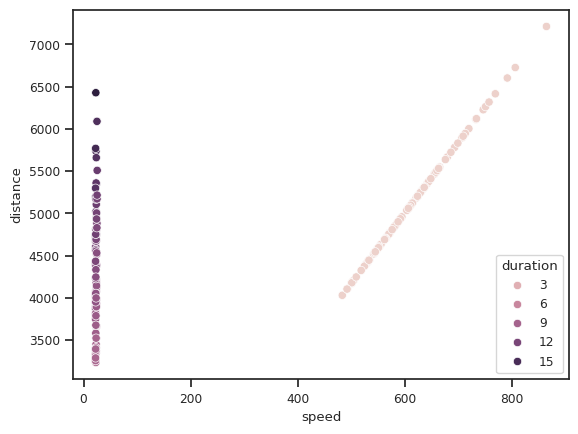

In [94]:
sb.scatterplot(anomal_rides, x='speed', hue='duration', y='distance')

In [95]:
print('аномальная скорость зафиксирована с дистанции {:.0f} м'.format(anomal_rides['distance'].min()))

аномальная скорость зафиксирована с дистанции 3236 м


Пометим для bug-report что аномальная скорость фиксируется на дистанции более 3км

Найдем среднее время затраченное на поездку и основную длительность поездок.

In [96]:
duration_bound_min, duration_bound_max = get_bounds_center_and_std(rides['duration'])

print(f'Cредняя длительность поездки: ',
      round(rides['duration'].mean()), 'мин')
print(
    f'В основном поездки длятся от {duration_bound_min} до {duration_bound_max} мин')

Cредняя длительность поездки:  18 мин
В основном поездки длятся от 12 до 24 мин


### Объединение данных

Обьединим данные о пользователях, поездках и подписках в один датафрейм

In [97]:
total_data = users.merge(rides,
                         on='user_id', how='inner')

total_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,speed
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,10.335841
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,9.929620
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,7.260713
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,8.734644
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,9.202888


In [98]:
total_data = total_data.merge(
    subscriptions, on='subscription_type', how='inner')
total_data.head().T

,0,1,2,3,4
user_id,1,1,1,1,1
name,Кира,Кира,Кира,Кира,Кира
age,22,22,22,22,22
city,Тюмень,Тюмень,Тюмень,Тюмень,Тюмень
subscription_type,ultra,ultra,ultra,ultra,ultra
distance,4409.91914,2617.592153,754.159807,2694.783254,4028.687306
duration,25.599769,15.816871,6.232113,18.511,26.265803
date,2021-01-01 00:00:00,2021-01-18 00:00:00,2021-04-20 00:00:00,2021-08-11 00:00:00,2021-08-28 00:00:00
month,1,1,4,8,8
speed,10.335841,9.92962,7.260713,8.734644,9.202888


Проверим количество строк таблицы до и после обьединения. Так как таблица `rides` дополняется данными из двух других таблиц (добавляются столбцы), то сравнивать будем ее с таблицей `total_data`

In [99]:
print('Строк в таблице rides:', len(rides))
print('Строк в таблице total_data:', len(total_data))

Строк в таблице rides: 17887
Строк в таблице total_data: 17887


Количество строк до и после слияния одинаково. Слияние прошло успешно

Создадим 2 датафрейма - в одном пользователи с подпиской, в другом - без.

In [100]:
users_free = total_data.query('subscription_type=="free"')
users_ultra = total_data.query('subscription_type=="ultra"')

### Построение графиков длительности сессий и расстояний для каждой категории пользователей.

#### Дистанция пройденная пользователями с подпиской и без нее

Text(0, 0.5, 'количество')

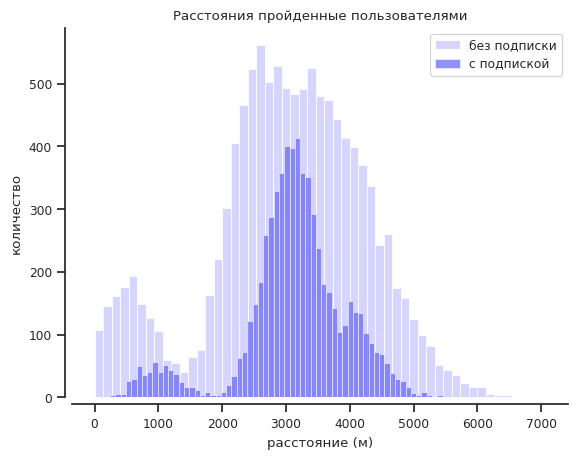

In [101]:
colors = '#C7C7FF', '#6B6BFF'

sb.histplot(users_free['distance'], color=colors[0])
sb.histplot(users_ultra['distance'], color=colors[1])


sb.despine(offset=5)
plt.legend(['без подписки', 'с подпиской'])
plt.title('Расстояния пройденные пользователями')
plt.xlabel('расстояние (м)')
plt.ylabel('количество')

Пользователи с подпиской преодолевают расстояния (см. вторые пики) в основном 2.5-4 км , а без нее - 2-4.5 км 

Загадкой по-прежнему остаются первые пики. 

#### Длительность поездок пользователей с подпиской и без нее

Text(0, 0.5, 'количество')

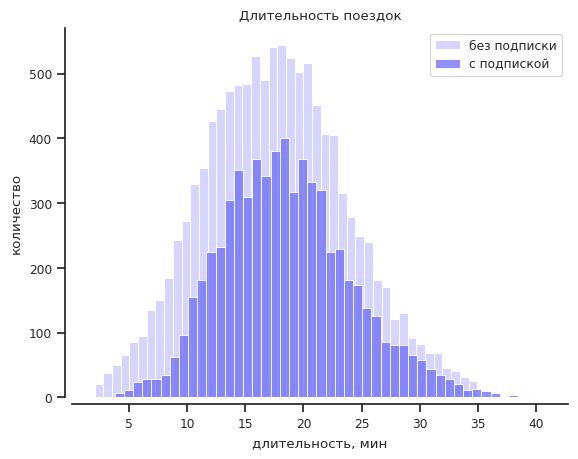

In [102]:
sb.histplot(users_free['duration'], color=colors[0])
sb.histplot(users_ultra['duration'], color=colors[1])
sb.despine(offset=5)
plt.legend(['без подписки', 'с подпиской'])
plt.title('Длительность поездок')
plt.xlabel('длительность, мин')
plt.ylabel('количество')

Распределения напоминают друг друга очертаниями - похоже, что приезжают в одни и те же места независимо от подписки.  

In [103]:
print('В основном, длительность поездок пользователей')
for value, name in zip([users_free['duration'],
                        users_ultra['duration']],

                       ['без подписки',
                        'с подпиской']):

    duration_bound_min, duration_bound_max = get_bounds_center_and_std(value)
    print(
        f'{name.upper()} от {duration_bound_min} до {duration_bound_max} мин')

В основном, длительность поездок пользователей
БЕЗ ПОДПИСКИ от 11 до 24 мин
С ПОДПИСКОЙ от 13 до 24 мин


### Подсчет выручки


Округлим длительности поездок принудительно до целого

In [104]:
total_data['duration'] = np.ceil(total_data['duration'])

Создадим сводную таблицу, в ключающую в себя, по месяцам, длительность поездок, пройденное расстояние, количество поездок

In [105]:
aggregate_data = total_data.pivot_table(index=['user_id', 'month'],

                                        values=['distance',
                                                'duration',
                                                'start_ride_price',
                                                'minute_price',
                                                'subscription_fee',
                                                'subscription_type'],

                                        aggfunc={'distance': 'sum',
                                                 'duration': 'sum',
                                                 'start_ride_price': 'first',
                                                 'minute_price': 'first',
                                                 'subscription_fee': 'first',
                                                 'subscription_type': 'first'})


# проверим
aggregate_data.head(10)

distance  duration  minute_price  start_ride_price  \
user_id month                                                           
1       1       7027.511294      42.0             6                 0   
        4        754.159807       7.0             6                 0   
        8       6723.470560      46.0             6                 0   
        10      5809.911100      32.0             6                 0   
        11      7003.499363      56.0             6                 0   
        12      6751.629942      28.0             6                 0   
2       3      10187.723006      63.0             6                 0   
        4       6164.381824      40.0             6                 0   
        6       3255.338202      14.0             6                 0   
        7       6780.722964      48.0             6                 0   

               subscription_fee subscription_type  
user_id month                                      
1       1                   199             ultra  
        4                   199             ultra  
        8                   199             ultra  
        10                  199             ultra  
        11                  199             ultra  
        12                  199             ultra  
2       3                   199             ultra  
        4                   199             ultra  
        6                   199             ultra  
        7                   199             ultra

Добавим столбец с количесвсвом поездок за месяц и переместим столбец в начало для удобства чтения таблицы

In [106]:
aggregate_data['count_rides'] = total_data.pivot_table(index=['user_id', 'month'],
                                                       values='distance',
                                                       aggfunc='count')
# переставляем новый столбец в начало
aggregate_data.insert(0, 'count_rides', aggregate_data.pop('count_rides'))
aggregate_data.head()

count_rides     distance  duration  minute_price  \
user_id month                                                     
1       1                2  7027.511294      42.0             6   
        4                1   754.159807       7.0             6   
        8                2  6723.470560      46.0             6   
        10               2  5809.911100      32.0             6   
        11               3  7003.499363      56.0             6   

               start_ride_price  subscription_fee subscription_type  
user_id month                                                        
1       1                     0               199             ultra  
        4                     0               199             ultra  
        8                     0               199             ultra  
        10                    0               199             ultra  
        11                    0               199             ultra

Переименуем столбцы

In [107]:
aggregate_data = (aggregate_data
                  .rename(
                      columns={'distance': 'total_distance',
                               'duration': 'total_duration'}))
aggregate_data.head()

count_rides  total_distance  total_duration  minute_price  \
user_id month                                                              
1       1                2     7027.511294            42.0             6   
        4                1      754.159807             7.0             6   
        8                2     6723.470560            46.0             6   
        10               2     5809.911100            32.0             6   
        11               3     7003.499363            56.0             6   

               start_ride_price  subscription_fee subscription_type  
user_id month                                                        
1       1                     0               199             ultra  
        4                     0               199             ultra  
        8                     0               199             ultra  
        10                    0               199             ultra  
        11                    0               199             ultra

Формула расчета стоимости   
стоимость_старта_поездки * количество_поездок + стоимость_1_мин * общая_продолжитиельность_поездок + стоимость_подписки 

In [108]:
aggregate_data['revenue'] = (aggregate_data['start_ride_price'] *
                             aggregate_data['count_rides'] +
                             aggregate_data['minute_price'] *
                             aggregate_data['total_duration'] +
                             aggregate_data['subscription_fee'])
aggregate_data.head()

count_rides  total_distance  total_duration  minute_price  \
user_id month                                                              
1       1                2     7027.511294            42.0             6   
        4                1      754.159807             7.0             6   
        8                2     6723.470560            46.0             6   
        10               2     5809.911100            32.0             6   
        11               3     7003.499363            56.0             6   

               start_ride_price  subscription_fee subscription_type  revenue  
user_id month                                                                 
1       1                     0               199             ultra    451.0  
        4                     0               199             ultra    241.0  
        8                     0               199             ultra    475.0  
        10                    0               199             ultra    391.0  
        11                    0               199             ultra    535.0

### Проверка гипотез

Нулевая гипотеза -   пользователи с подпиской тратят  времени на поездки столько же сколько пользователи без подписки.  
Альтернативная гипотеза -  пользователи с подпиской тратят БОЛЬШЕ времени на поездки, чем пользователи без подписки.

In [109]:
hipotesys_1 = {'H_0': 'пользователи с подпиской тратят  времени на поездки столько же сколько пользователи без подписки',
               'H_1': 'пользователи с подпиской тратят БОЛЬШЕ времени на поездки, чем пользователи без подписки.'}

In [110]:
alpha = 0.05
print('Средняя подолжительность поездок пользователей')
print(f'с подпиской: {round(users_ultra["duration"].mean(),3)} мин')
print(f'без подписки: {round(users_free["duration"].mean(),3)} мин\n')

# применяем двухвыборочный т-тест для независмых выборок с правосторонней альт. гипотезой
results = st.ttest_ind(
    users_ultra['duration'], users_free['duration'], alternative='greater')

print('p-value:', results.pvalue)


if results.pvalue < alpha:
    print(f'Результаты в пользу альт. гипотезы - {hipotesys_1.get("H_1")}')
else:
    print(f'Не отвергаем нулевую гипотезу о {hipotesys_1.get("H_0")}')

Средняя подолжительность поездок пользователей
с подпиской: 18.542 мин
без подписки: 17.578 мин

p-value: 1.2672869409276102e-25
Результаты в пользу альт. гипотезы - пользователи с подпиской тратят БОЛЬШЕ времени на поездки, чем пользователи без подписки.


Вывод: выходит, что пользователи с подпиской тратят на поездки больше времени, чем пользователи без нее

Нулевая гипотеза -среднее расстояние, пройденное пользователями с подпиской, равно значению 3130 метров(оптимальное расстояние с точки зрения износа самоката)  
Альтернативная гипотеза - среднее расстояние, пройденное пользователями с подпиской, БОЛЬШЕ 3130 метров


In [111]:
hipotesys_2 = {'H_0': '''среднее расстояние,
             пройденное пользователями с подпиской,
             равно значению 3130 метров(оптимальное расстояние с точки зрения износа самоката) ''',

               'H_1': '''среднее расстояние,
           пройденное пользователями с подпиской,
           БОЛЬШЕ 3130 метров'''}

In [112]:
optimal_value = 3130
alpha = 0.05

# применяем одновыборочный t-test / проверяется правосторонняя альт. гипотеза
results = st.ttest_1samp(
    users_ultra['distance'], optimal_value, alternative='greater')

print('p-value:', '{:.3}'.format(results.pvalue))

if results.pvalue < alpha:
    print(f'Результаты в пользу альт. гипотезы - {hipotesys_2.get("H_1")}')
else:
    print(f'Не отвергаем нулевую гипотезу - {hipotesys_2.get("H_0")}')

p-value: 0.92
Не отвергаем нулевую гипотезу - среднее расстояние,
             пройденное пользователями с подпиской,
             равно значению 3130 метров(оптимальное расстояние с точки зрения износа самоката) 


Вывод: пользователи с подпиской проходят расстояние равное 3130 метров, а значит  самокаты не будут изнашиваться быстрее.

Нулевая гипотеза  - помесячная выручка от пользователей с подпиской по месяцам равна выручке пользователей без подписки.  
Альтернативная гипотеза - помесячная выручка от пользователей с подпиской по месяцам БОЛЬШЕ, чем выручка от пользователей без подписки.

In [113]:
hipotesys_3 = {'H_0': '''помесячная выручка от пользователей с подпиской по месяцам 
             равна выручке пользователей без подписки.''',

               'H_1': '''помесячная выручка от пользователей с подпиской по месяцам БОЛЬШЕ,
           чем выручка от пользователей без подписки'''}

In [114]:
alpha = 0.05

# выручка пользователей с подпиской
revenue_user_ultra = (aggregate_data['revenue']
                      .loc[
                          aggregate_data['subscription_type'] == 'ultra'])

# выручка пользователей без подписки
revenue_user_free = (aggregate_data['revenue']
                     .loc[
                         aggregate_data['subscription_type'] == 'free'])

# применяем двухвыборочный t-test для независимых выборок с правостороннней альтернативной гипотезой
results = (st
           .ttest_ind(
               revenue_user_ultra,
               revenue_user_free,
               alternative='greater'))

print('p-value:', '{:.3}'.format(results.pvalue))

if results.pvalue < alpha:
    print(f'Результаты в пользу альт. гипотезы - {hipotesys_3.get("H_1")}')
else:
    print(f'Не отвергаем нулевую гипотезу - {hipotesys_3.get("H_0")}')

p-value: 1.94e-31
Результаты в пользу альт. гипотезы - помесячная выручка от пользователей с подпиской по месяцам БОЛЬШЕ,
           чем выручка от пользователей без подписки


Вывод: значит помесячная выручка пользователей с подпиской выше чем помесячная выручка пользователей без подписки

## Итоговый вывод  

Устранив дубликаты, приведя формат даты к необходимому, ислледовали данные, взятые за период с 01-01-2021 по 30-12-2021 гг о пользователях севиса аренды самокатов GoFast, а также, обьединив 3 таблицы о пользователях, поездках, подписках рассчитали выручку помесячно для каждого пользователя и проверили следующие гипотезы: 
1. тратят ли пользователи с подпиской больше времени на поездки
2. проезжают ли пользователи с подпиской больше оптимального расстояния с точки зрения износа  самоката
3. приносят ли пользователи с подпиской больше выручки чем пользователи без нее.

Обнаружено следующее:  
Больше всего пользователей обнаружено в г.Пятигорске, меньше - в Москве;  
услугой сервиса пользуются граждане от 12 до 43 лет;   
но в основном арендуют пользователи от 20 до 29 лет;
пользователей без подписки больше пользователей с подпиской (54.4% против 45.4% соответсвенно);
пользователи без подписки проезжают расстояния от 2 до 4.5 км,  
с подпиской - 2.5 - 4 км, а в целом все пользователи проезжают расстояния от 2 - 4.5 км;
длительность поездок пользователей обоех групп почти одинакова : с подпиской - 11-24 мин, без подписки - 13-24 мин.  

Проверив гипотезы, приходим к выводам, что  
в отличии от пользователей без подписки, пользователи с подпиской тратят больше времени на поездки,но проезжают расстояния в основном раное опттимальному расстояния с точки  зрения износа самоката, то есть 3130 метров, и приносят больше выручки , а значит, являются более выгодными для компании.

Рекомендации.
1. Уделить больше внимания техническому обслуживанию самокатов.
2. Уделить внимание расчетам времени поездок и расстояния. 


Баг-репорт   
1. обнаружены строки-дубликаты в таблице с пользователями (файл users_go.csv). Причиной может быть техническая сторона.  
2. обнаружены проблемы с расчетом времени поездок (95 поездок завершились ровно за 30 сек.) и расстояний (некоторые дистанции исчисляются несколькими метрами или вовсе меньше метра )
